In [1]:
# PREAMBLE
# system imports, set proto-models paths
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent.as_posix()))
sys.path.insert(0, str(Path.cwd().parent.parent.as_posix()))

In [2]:
import numpy as np
from combinations import pseudo_distribution, pseudo_gen

In [3]:
# import pathfinder to plot bam and result example
import pathfinder as pf
from pathfinder import plot_results

In [4]:
# Fitting
from scipy.stats import norm
from iminuit import Minuit
from iminuit.cost import UnbinnedNLL

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["font.family"] = "serif"
plt.rcParams["axes.grid"] = False
plt.rcParams['text.kerning_factor'] = 0

In [6]:
# Input slhafile
slhafile = '../inputFiles/slha/gluino_squarks.slha'
bd_path = 'official'
bd_path = '/Users/jamieyellen/.cache/smodels/official300-beta_copy.pcl'

In [79]:
# BAM Plotting
def plot_bam(bam, weights) -> None:
    bw = pseudo_distribution.get_bam_weight(bam, weights)
    bam = pf.BinaryAcceptance(bw['bam'], weights=bw['weights'])
    result = pf.WHDFS(bam)
    result.find_paths()
    plot_results.plot(bam, result=result, size=10)

##### Get 500 pseudo results under the SM hypothesis at model point defined by input file.

##### The results are returned as a list of weights and overlaps:

$\rightarrow$ {'weights': {'label': [weight]}, 'bam': {lebel: {set of non overlapping labels}}}

Where each weight is defined as: $w_i = \frac{\mathrm{L}(\mu=0|\theta)}{\mathrm{L}(\mu=1|\theta)}$

In [8]:
sudo_data = pseudo_gen.get_pseudo_llr(slhafile, data_base=bd_path, bootstrap_num=500, proc=4)
len(sudo_data)

[helpers] seeding the random number generators with 355141. Here is a first realization of a standard normal: -2.191
[expResModifier:0] setting random seed to 355141
[helpers] seeding the random number generators with 296426. Here is a first realization of a standard normal: -0.382
[expResModifier:0] setting random seed to 296426
[helpers] seeding the random number generators with 458925. Here is a first realization of a standard normal: 0.392
[expResModifier:0] setting random seed to 458925
[helpers] seeding the random number generators with 604458. Here is a first realization of a standard normal: 0.343
[expResModifier:0] setting random seed to 604458
[expResModifier:0]  `- skipping UL-type ATLAS-EXOT-2018-48
[expResModifier:0]  `- skipping UL-type ATLAS-EXOT-2019-03
[expResModifier:0]  `- skipping UL-type ATLAS-SUSY-2015-01
[expResModifier:0]  (quenching more of the msgs given above)
[expResModifier:0]  `- skipping UL-type ATLAS-EXOT-2018-48
[expResModifier:0]  `- skipping UL-type A

500

##### Get proper result at model point defined by input file. 

In [9]:
real_data = pseudo_gen.get_llr_at_point(slhafile, data_base=bd_path)

##### Plot the proper result BAM with top 10 paths

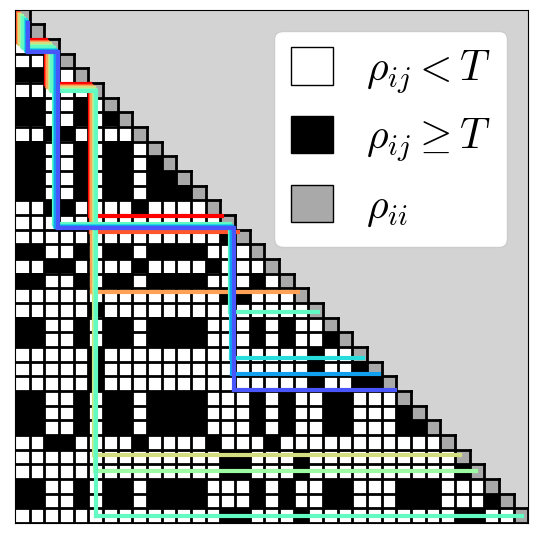

In [80]:
plot_bam(real_data['bam'], real_data['weights'])

##### Find best sets of combinations for both the real dan pseudo data 

In [11]:
real_res = pseudo_distribution.find_best_sets([real_data], num_cor=1)

Starting job 1. Calculating 1 best combinations


In [24]:
sudo_res_sets = pseudo_distribution.find_best_sets(sudo_data, num_cor=2)

Starting job 1. Calculating 250 best combinations
Starting job 2. Calculating 250 best combinations


##### evaluate the results

##### $x^\prime = \sum_i^N w_i $ - (N - 1)

##### $x = \frac{x^\prime - E[x^\prime]}{\sqrt{E[x^{\prime2}] -  E[x^\prime]^2}} = \frac{x^\prime - \mu_{x^\prime}}{ \sigma_{x^\prime}}$


In [66]:
path_lengths = np.array([len(item['path']) for _, item in sudo_res_sets.items()])
sudo_res = np.array([item['weight'] for _, item in sudo_res_sets.items()]) - (path_lengths - 1)
sudo_rescale = (sudo_res - sudo_res.mean())/np.std(sudo_res, ddof=1)
best_rescale = (real_res[0]['weight'] - sudo_res.mean())/np.std(sudo_res, ddof=1)

In [67]:
# fid unbinned data to normal pdf
def data_fit(sudo_rescale, mu=0, sig=1) -> Minuit:
    def wrap_pdf(x, mu, sig):
        return norm.pdf(x, loc=mu, scale=sig)
    nll = UnbinnedNLL(sudo_rescale, wrap_pdf)
    im_fit = Minuit(nll, mu, sig)
    im_fit.fixed['mu'] = False
    im_fit.fixed['sig'] = False
    im_fit.scan()
    im_fit.hesse()
    return im_fit

In [68]:
fit = data_fit(sudo_rescale)
print(fit)
cdf = norm.cdf(best_rescale, fit.values['mu'], fit.values['sig'])
print(f': Analytic {1. - cdf}')

┌─────────────────────────────────────────────────────────────────────────┐
│                                 Scan                                    │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1418                       │              Nfcn = 427              │
│ EDM = 0.0141 (Goal: 0.1)         │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

##### Plot PDF

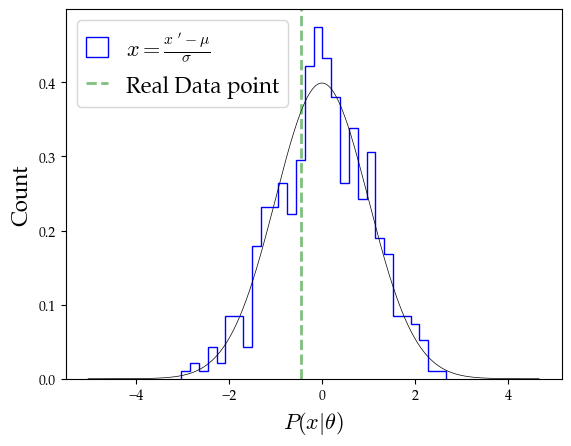

In [83]:
fig, ax0 = plt.subplots()
range = (sudo_rescale.min()-2, sudo_rescale.max()+2)
ax0.hist(sudo_rescale, bins=30, color='lightblue', edgecolor='b', histtype='step', density=True,
        label=r"$x = \frac{x\ ^\prime - \mathcal{\mu}}{\mathcal{\sigma}}$")
ax0.plot(np.linspace(*range, 1000), norm.pdf(np.linspace(*range, 1000), fit.values['mu'], fit.values['sig']),
        c='k', lw=0.5, ls='-')
ax0.axvline(best_rescale, ls='--', color='g', lw=2, alpha=0.5, label='Real Data point')
ax0.set_ylabel("Count", fontsize=16)
ax0.set_xlabel(r"$P(x| \theta)$", fontsize=16)
ax0.legend(loc=2, prop={'size': 16})
plt.show()

##### Plot p-value (1 - CDF) 

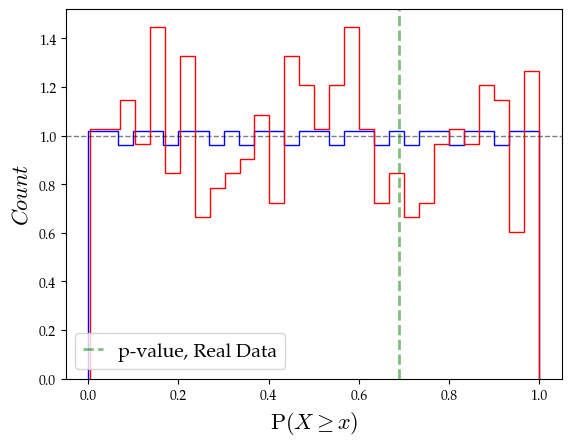

In [85]:
fig, ax1 = plt.subplots()
pvals = np.array([(sudo_rescale > val).sum() for val in sudo_rescale])/(len(sudo_rescale) - 1)
pvals2 = norm.sf(sudo_rescale, fit.values['mu'], fit.values['sig'])
fil_num, _, _ = ax1.hist(pvals, bins=30, color='lightblue', edgecolor='b', histtype='step', density=True,)
fil_num0, _, _ = ax1.hist(pvals2, bins=30, color='lightblue', edgecolor='r', histtype='step', density=True,)
# ax1.axhline(np.mean(fil_num), ls='--', color='r', lw=1, alpha=0.5)
ax1.axhline(1, ls='--', color='k', lw=1, alpha=0.5)
ax1.axvline((sudo_rescale > best_rescale).sum()/len(sudo_rescale-1), ls='--', color='g',
            lw=2, alpha=0.5, label='p-value, Real Data')
ax1.set_ylabel(r"$Count$", fontsize=16)
ax1.set_xlabel(r"$\mathrm{P}(X \geq x)$", fontsize=16)
ax1.legend(loc=3, prop={'size': 14})
plt.show()
plt.close()